In [ ]:
!pip install tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-08 02:59:52--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.174.200, 52.217.226.32, 16.182.68.192, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.174.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.47MB/s    in 2.4s    

2024-04-08 02:59:55 (5.47 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Examination of the Jena weather dataset's 420451 rows and 15 features

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

line1 = data.split("\n")
header1 = line1[0].split(",")
line1 = line1[1:]
print(header1)
print(len(line1))

num_var = len(header1)
print("Number of variables:", num_var)
num_rows = len(line1)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


After analysis of the data, certain values are stored for further processing or analysis in the raw_data and temperature arrays. To create floating-point numbers, values separated by commas are converted.

In [ ]:
import numpy as np
temp1 = np.zeros((len(line1),))
raw_d = np.zeros((len(line1), len(header1) - 1))
for i, line in enumerate(line1):
    values = [float(x) for x in line.split(",")[1:]]
    temp1[i] = values[1]
    raw_d[i, :] = values[:]

The timeseries plot of temperature

Text(0, 0.5, 'Temperature')

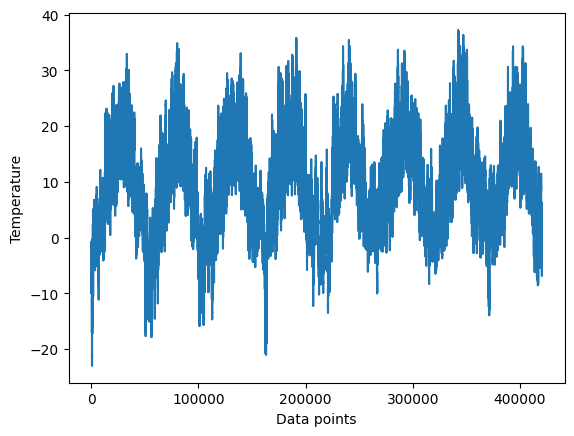

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temp1)), temp1)
plt.xlabel('Data points')
plt.ylabel('Temperature')

For the first ten days, the temperature time series is plotted. A day's worth of data collection equals 144 data points; thus, ten days will yield 1440 data points.

Text(0, 0.5, 'Temperature')

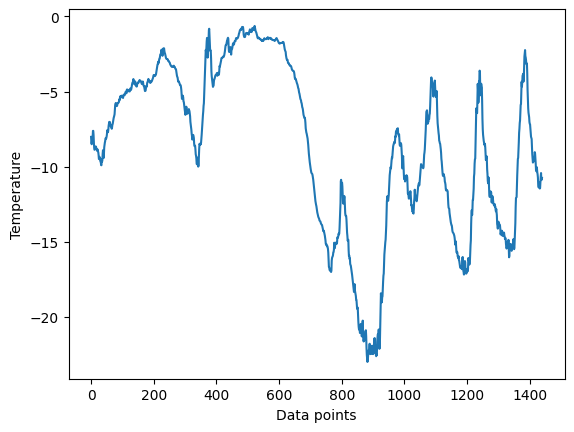

In [ ]:
plt.plot(range(1440), temp1[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

Estimating the number of samples required for each data split (validation = 25%, train = 50%).

In [ ]:
num_of_train = int(0.5 * len(raw_d))
num_of_val= int(0.25 * len(raw_d))
num_of_test= len(raw_d) - num_of_train - num_of_val
print("Number of train samples:", num_of_train)
print("Number of validation samples:", num_of_val)
print("Number of test samples:", num_of_test)

Number of train samples: 210225
Number of validation samples: 105112
Number of test samples: 105114


Getting the information ready

normalization of the data: Vectorization is not required because the data is already represented numerically. However, it is advisable to standardize all variables because the data scales differ among them (temperature ranges from -20 to +30, and pressure is measured in millibars).

In [ ]:
mean1 = raw_d[:num_of_train].mean(axis=0)
raw_d -= mean1
std = raw_d[:num_of_train].std(axis=0)
raw_d /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence1 = np.arange(10)
dummy_d = keras.utils.timeseries_dataset_from_array(
    data=int_sequence1[:-3],
    targets=int_sequence1[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_d:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


It is imperative to create training, validation, and testing datasets due to the substantial amount of duplication in the dataset's sample. For every sample, it would be inefficient to actively allocate RAM. Real-time generation of the samples will occur instead.

In [ ]:
sample_rate = 6
sequencelength = 120
delay = sample_rate * (sequencelength + 24 - 1)
batch_size = 256

training_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_of_train)

validation_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train,
    end_index=num_of_train + num_of_val)

testing_data = keras.utils.timeseries_dataset_from_array(
    raw_d[:-delay],
    targets=temp1[delay:],
    sampling_rate=sample_rate,
    sequence_length=sequencelength,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_of_train + num_of_val)

Producing the result of one of these databases

In [ ]:
for samples, targets in training_data:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


A sensible baseline that isn't powered by machines

Establishing the sensible baseline MAE: Using the final value in the input sequence as a starting point, the function "evaluate_naive_method" is specified. This function offers a basis for assessing the effectiveness of a straightforward forecasting method.

In [ ]:
def evaluate_naive_method(dataset):
    total_absolute_error = 0.
    samples_saw = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean1[1]
        total_absolute_error += np.sum(np.abs(preds - targets))
        samples_saw += samples.shape[0]
    return total_absolute_error / samples_saw

print(f"Validation MAE: {evaluate_naive_method(validation_data):.2f}")
print(f"Test MAE: {evaluate_naive_method(testing_data):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


A common sense approach would be to forecast that the temperature will remain unchanged in 24 hours. The test mean, using this basic baseline, is 2.62 degrees Celsius, while the validation mean absolute error (MAE) is 2.44 degrees. Said another way, if the future temperature remained constant with the current one, there would be an average difference of about 2.5 degrees.

An introduction to machine learning: Dense Layer

Putting a densely connected model through training and assessment

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
G1 = layers.Flatten()(inputs)
G1 = layers.Dense(16, activation="relu")(G1)
outputs = layers.Dense(1)(G1)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])


history = model.fit(training_data, epochs=5,
                    validation_data = validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 11s 13ms/step - loss: 11.9236 - mae: 2.6810 - val_loss: 10.2779 - val_mae: 2.5297
Epoch 2/5
819/819 [==============================] - 10s 13ms/step - loss: 8.7532 - mae: 2.3208 - val_loss: 10.3049 - val_mae: 2.5250
Epoch 3/5
819/819 [==============================] - 11s 13ms/step - loss: 8.0483 - mae: 2.2272 - val_loss: 10.5085 - val_mae: 2.5540
Epoch 4/5
819/819 [==============================] - 11s 13ms/step - loss: 7.6625 - mae: 2.1728 - val_loss: 10.2993 - val_mae: 2.5212
Epoch 5/5
819/819 [==============================] - 10s 13ms/step - loss: 7.3605 - mae: 2.1309 - val_loss: 11.0152 - val_mae: 2.6124


In [ ]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 4s 8ms/step - loss: 11.7493 - mae: 2.6864
Test MAE: 2.69


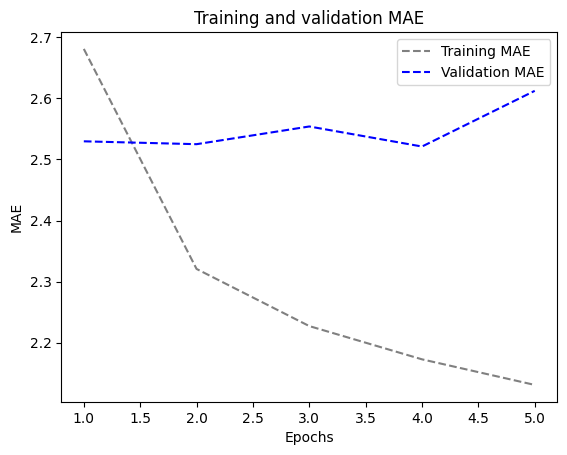

In [ ]:
import matplotlib.pyplot as plt
loss1 = history.history["mae"]
validation_loss = history.history["val_mae"]

epochs = range(1, len(loss1) + 1)
plt.figure()
plt.plot(epochs, loss1, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

We will attempt a 1D convolutional model.

In [ ]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history1D = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

model_to_dot = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 15s 17ms/step - loss: 22.5134 - mae: 3.7202 - val_loss: 16.2194 - val_mae: 3.1922
Epoch 2/5
819/819 [==============================] - 14s 18ms/step - loss: 16.0800 - mae: 3.1961 - val_loss: 16.2212 - val_mae: 3.2159
Epoch 3/5
819/819 [==============================] - 15s 18ms/step - loss: 14.8814 - mae: 3.0719 - val_loss: 15.1146 - val_mae: 3.0500
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 13.9340 - mae: 2.9668 - val_loss: 21.1275 - val_mae: 3.7172
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 19.3020 - mae: 3.5620
Test MAE: 3.56


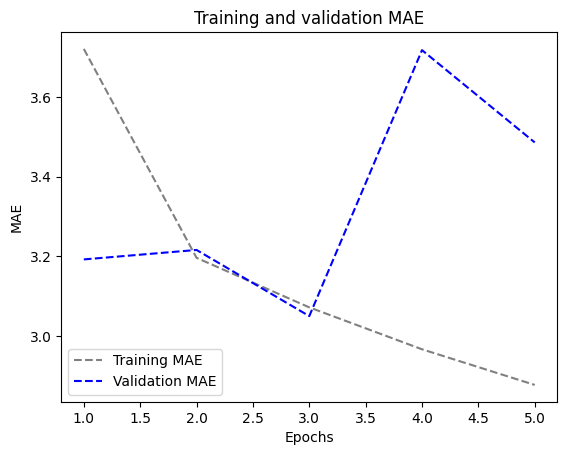

In [ ]:
import matplotlib.pyplot as plt
loss1D = history1D.history["mae"]
validation_loss1D = history1D.history["val_mae"]

epochs = range(1, len(loss1D) + 1)
plt.figure()
plt.plot(epochs, loss1D, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss1D, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Convolutional data appears to perform worse than dense models or common sense. That may be as a result of

The translation invariance assumption is not met by weather data. It matters what order the information is presented in. When predicting the temperature for the following day, recent historical data is noticeably more useful than data collected many days in advance. Sadly, this important temporal order cannot be sufficiently represented by a 1D convolutional neural network.

A Basic RNN

1. A layer of RNN capable of processing any length of sequence

In [ ]:
the_features = 14
input_RNN = keras.Input(shape=(None, the_features))
output_RNN = layers.SimpleRNN(16)(input_RNN)

models_RNN = keras.Model(input_RNN, output_RNN)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
models_RNN.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_RNN = models_RNN.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_RNN = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {models_RNN.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 22s 26ms/step - loss: 138.5464 - mae: 9.6699 - val_loss: 143.8626 - val_mae: 9.8808
Epoch 2/5
819/819 [==============================] - 21s 26ms/step - loss: 136.2806 - mae: 9.5495 - val_loss: 143.7980 - val_mae: 9.8758
Epoch 3/5
819/819 [==============================] - 21s 26ms/step - loss: 136.2187 - mae: 9.5454 - val_loss: 143.7798 - val_mae: 9.8756
Epoch 4/5
819/819 [==============================] - 21s 26ms/step - loss: 136.1670 - mae: 9.5407 - val_loss: 143.6901 - val_mae: 9.8676
Epoch 5/5
405/405 [==============================] - 5s 11ms/step - loss: 151.5715 - mae: 9.9514
Test MAE: 9.95


2.Simple RNN - Stacking RNN layers

In [ ]:
the_features2 = 14
steps = 120
inpu2 = keras.Input(shape=(steps, the_features2))
a = layers.SimpleRNN(16, return_sequences=True)(inpu2)
a = layers.SimpleRNN(16, return_sequences=True)(a)
outpu2 = layers.SimpleRNN(16)(a)
models2 = keras.Model(inpu2, outpu2)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
models2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history2 = models2.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models2 = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {models2.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 65s 77ms/step - loss: 137.0812 - mae: 9.5858 - val_loss: 143.4113 - val_mae: 9.8324
Epoch 2/5
819/819 [==============================] - 62s 76ms/step - loss: 135.9930 - mae: 9.5171 - val_loss: 143.4547 - val_mae: 9.8417
Epoch 3/5
819/819 [==============================] - 62s 76ms/step - loss: 135.9434 - mae: 9.5114 - val_loss: 143.3823 - val_mae: 9.8285
Epoch 4/5
819/819 [==============================] - 62s 76ms/step - loss: 135.9079 - mae: 9.5056 - val_loss: 143.3933 - val_mae: 9.8329
Epoch 5/5
405/405 [==============================] - 10s 23ms/step - loss: 151.1423 - mae: 9.9020
Test MAE: 9.90


A Simple GRU (Gated Recurrent Unit)

In [ ]:
inputs_GRU = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
b = layers.GRU(16)(inputs_GRU)
outputs_GRU = layers.Dense(1)(b)
models_GRU = keras.Model(inputs_GRU, outputs_GRU)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
models_GRU.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_GRU = models_GRU.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

models_GRU = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {models_GRU.evaluate(testing_data)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 52s 61ms/step - loss: 35.1561 - mae: 4.2908 - val_loss: 11.3594 - val_mae: 2.5578
Epoch 2/5
819/819 [==============================] - 50s 60ms/step - loss: 10.3698 - mae: 2.5131 - val_loss: 9.5023 - val_mae: 2.4012
Epoch 3/5
819/819 [==============================] - 49s 60ms/step - loss: 9.4691 - mae: 2.4053 - val_loss: 9.6384 - val_mae: 2.4021
Epoch 4/5
819/819 [==============================] - 50s 61ms/step - loss: 9.1557 - mae: 2.3628 - val_loss: 10.3044 - val_mae: 2.4503
Epoch 5/5
405/405 [==============================] - 9s 20ms/step - loss: 10.4989 - mae: 2.5402
Test MAE: 2.54


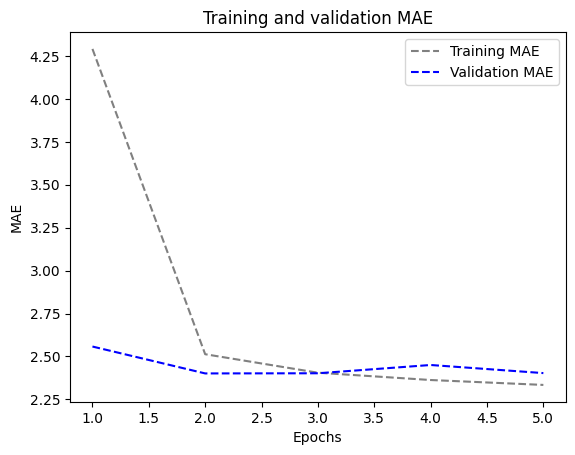

In [ ]:
import matplotlib.pyplot as plt
loss_GRU = history_GRU.history["mae"]
validation_loss_GRU = history_GRU.history["val_mae"]

epochs = range(1, len(loss_GRU) + 1)
plt.figure()
plt.plot(epochs, loss_GRU, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_GRU, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


LSTM(Long Short-Term Memory )

1.LSTM-Simple

In [ ]:
inputs_LSTMS = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
c = layers.LSTM(16)(inputs_LSTMS)
output_LSTMS = layers.Dense(1)(c)
model_LSTMS = keras.Model(inputs_LSTMS, output_LSTMS)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model_LSTMS.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMS = model_LSTMS.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 52s 61ms/step - loss: 44.4430 - mae: 4.8578 - val_loss: 12.6791 - val_mae: 2.7031
Epoch 2/5
819/819 [==============================] - 49s 60ms/step - loss: 11.1062 - mae: 2.5847 - val_loss: 9.9479 - val_mae: 2.4549
Epoch 3/5
819/819 [==============================] - 49s 60ms/step - loss: 9.7779 - mae: 2.4399 - val_loss: 9.5413 - val_mae: 2.4039
Epoch 4/5
819/819 [==============================] - 49s 60ms/step - loss: 9.2408 - mae: 2.3706 - val_loss: 9.6121 - val_mae: 2.4107
Epoch 5/5
819/819 [==============================] - 49s 60ms/step - loss: 8.8125 - mae: 2.3170 - val_loss: 10.1657 - val_mae: 2.4747


In [ ]:
model_LSTMS = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model_LSTMS.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 10s 23ms/step - loss: 10.6556 - mae: 2.5700
Test MAE: 2.57


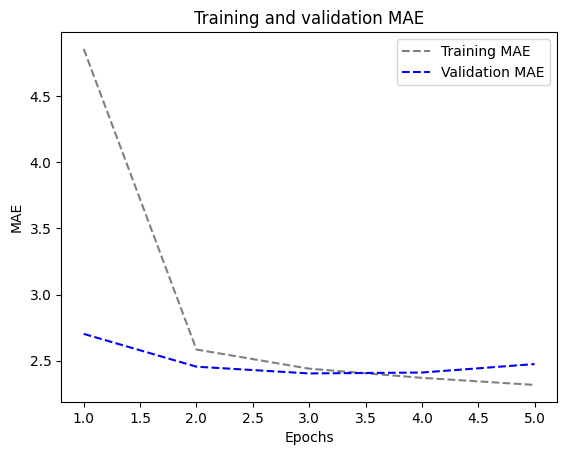

In [ ]:
import matplotlib.pyplot as plt
loss_LSTMS = history_LSTMS.history["mae"]
validation_loss_LSTMS = history_LSTMS.history["val_mae"]

epochs = range(1, len(loss_LSTMS) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMS, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMS, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

2.LSTM - dropout Regularization

In [ ]:
input_LSTMR = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
d = layers.LSTM(16, recurrent_dropout=0.25)(input_LSTMR )
d = layers.Dropout(0.5)(d)
output_LSTMR = layers.Dense(1)(d)
model_LSTMR = keras.Model(input_LSTMR , output_LSTMR )

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model_LSTMR.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_LSTMR = model_LSTMR.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 69s 82ms/step - loss: 49.4690 - mae: 5.2337 - val_loss: 13.7204 - val_mae: 2.7867
Epoch 2/5
819/819 [==============================] - 67s 81ms/step - loss: 19.9353 - mae: 3.4266 - val_loss: 9.8996 - val_mae: 2.4272
Epoch 3/5
819/819 [==============================] - 67s 81ms/step - loss: 18.3281 - mae: 3.2915 - val_loss: 9.4088 - val_mae: 2.3865
Epoch 4/5
819/819 [==============================] - 67s 81ms/step - loss: 17.6321 - mae: 3.2263 - val_loss: 9.3059 - val_mae: 2.3787
Epoch 5/5
819/819 [==============================] - 67s 81ms/step - loss: 17.0127 - mae: 3.1724 - val_loss: 9.3989 - val_mae: 2.3918


In [ ]:
model_LSTMR = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model_LSTMR.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 8s 20ms/step - loss: 10.8480 - mae: 2.5788
Test MAE: 2.58


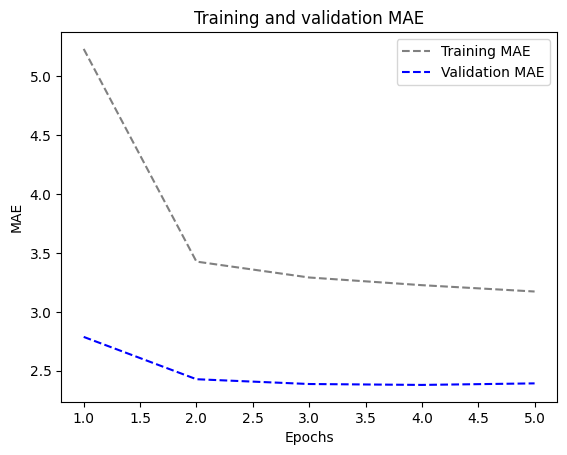

In [ ]:
import matplotlib.pyplot as plt
loss_LSTMR = history_LSTMR .history["mae"]
validation_loss_LSTMR = history_LSTMR .history["val_mae"]

epochs = range(1, len(loss_LSTMR) + 1)
plt.figure()
plt.plot(epochs, loss_LSTMR, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_LSTMR, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

3.LSTM - Stacked setup with 16 units

In [ ]:
input_16 = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
e = layers.LSTM(16, return_sequences=True)(input_16)
e = layers.LSTM(16)(e)
output_16 = layers.Dense(1)(e)
model_16 = keras.Model(input_16, output_16)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model_16.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_16 = model_16.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 100s 118ms/step - loss: 45.3879 - mae: 4.9131 - val_loss: 13.9209 - val_mae: 2.7888
Epoch 2/5
819/819 [==============================] - 96s 117ms/step - loss: 10.6568 - mae: 2.5249 - val_loss: 9.8609 - val_mae: 2.4452
Epoch 3/5
819/819 [==============================] - 96s 117ms/step - loss: 8.8871 - mae: 2.3306 - val_loss: 10.7152 - val_mae: 2.5371
Epoch 4/5
819/819 [==============================] - 96s 117ms/step - loss: 8.3136 - mae: 2.2597 - val_loss: 9.4993 - val_mae: 2.4151
Epoch 5/5
819/819 [==============================] - 96s 117ms/step - loss: 7.7326 - mae: 2.1826 - val_loss: 10.0639 - val_mae: 2.4819


In [ ]:
model_16 = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model_16.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 18s 42ms/step - loss: 10.8770 - mae: 2.5938
Test MAE: 2.59


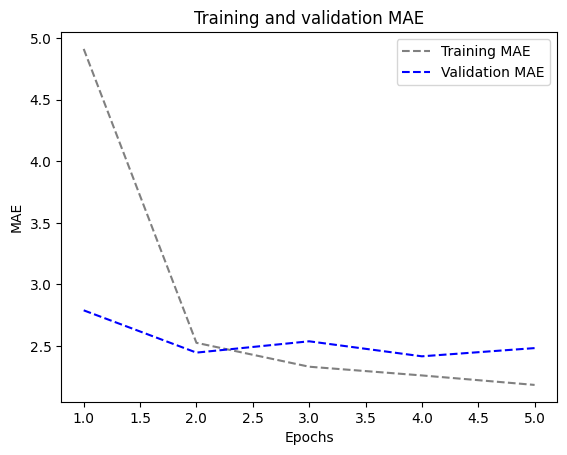

In [ ]:
import matplotlib.pyplot as plt
loss_16 = history_16.history["mae"]
validation_loss_16 = history_16.history["val_mae"]

epochs = range(1, len(loss_16) + 1)
plt.figure()
plt.plot(epochs, loss_16, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_16, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()


4.LSTM - Stacked setup with 32 units

In [ ]:
input_32 = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
f = layers.LSTM(32, return_sequences=True)(input_32)
f = layers.LSTM(32)(f)
output_32 = layers.Dense(1)(f)
model_32 = keras.Model(input_32, output_32)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model_32.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_32 = model_32.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 139s 165ms/step - loss: 19.5674 - mae: 3.1883 - val_loss: 9.5978 - val_mae: 2.4155
Epoch 2/5
819/819 [==============================] - 134s 164ms/step - loss: 8.1636 - mae: 2.2305 - val_loss: 9.8763 - val_mae: 2.4568
Epoch 3/5
819/819 [==============================] - 134s 163ms/step - loss: 6.6156 - mae: 2.0060 - val_loss: 10.0888 - val_mae: 2.4656
Epoch 4/5
819/819 [==============================] - 134s 164ms/step - loss: 5.6969 - mae: 1.8552 - val_loss: 11.0269 - val_mae: 2.5942
Epoch 5/5
819/819 [==============================] - 134s 163ms/step - loss: 4.8977 - mae: 1.7185 - val_loss: 11.2591 - val_mae: 2.6110


In [ ]:
model_32 = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model_32.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 27s 64ms/step - loss: 10.5974 - mae: 2.5487
Test MAE: 2.55


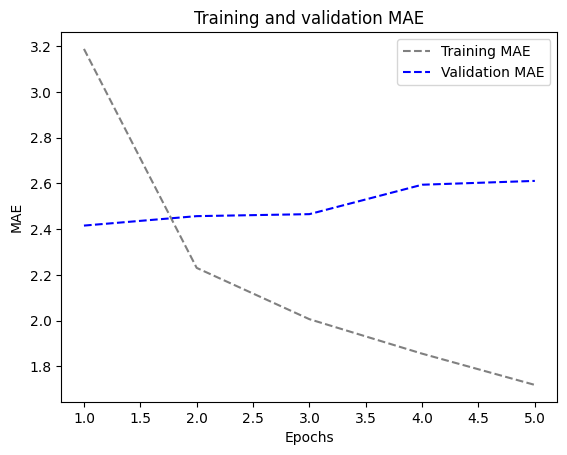

In [ ]:
import matplotlib.pyplot as plt
loss_32 = history_32.history["mae"]
validation_loss_32 = history_32.history["val_mae"]

epochs = range(1, len(loss_32) + 1)
plt.figure()
plt.plot(epochs, loss_32, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_32, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

5.LSTM - Stacked setup with 8 units

In [ ]:
input_8u = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
h = layers.LSTM(8, return_sequences=True)(input_8u)
h = layers.LSTM(8)(h)
output_8u = layers.Dense(1)(h)
model_8u = keras.Model(input_8u, output_8u)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model_8u.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history_8u = model_8u.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 84s 99ms/step - loss: 74.3017 - mae: 6.6348 - val_loss: 38.4667 - val_mae: 4.6480
Epoch 2/5
819/819 [==============================] - 79s 97ms/step - loss: 22.8469 - mae: 3.5362 - val_loss: 13.8061 - val_mae: 2.7861
Epoch 3/5
819/819 [==============================] - 80s 98ms/step - loss: 11.4657 - mae: 2.6161 - val_loss: 10.0600 - val_mae: 2.4608
Epoch 4/5
819/819 [==============================] - 80s 98ms/step - loss: 10.0365 - mae: 2.4654 - val_loss: 9.7330 - val_mae: 2.4235
Epoch 5/5
819/819 [==============================] - 81s 99ms/step - loss: 9.6984 - mae: 2.4241 - val_loss: 10.3888 - val_mae: 2.4604


In [ ]:
model_8u = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model_8u.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 14s 33ms/step - loss: 10.7918 - mae: 2.5750
Test MAE: 2.58


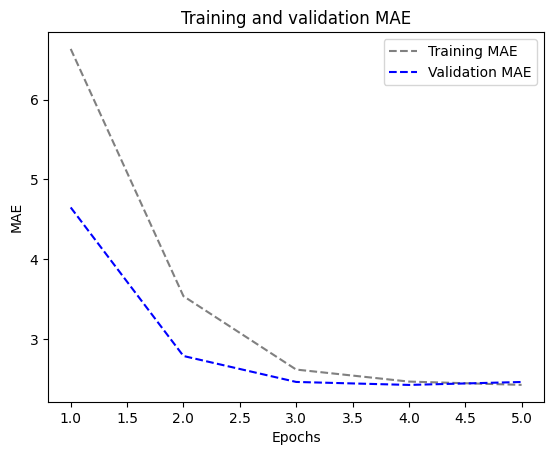

In [ ]:
import matplotlib.pyplot as plt
loss_8u = history_8u.history["mae"]
validation_loss_8u = history_8u.history["val_mae"]

epochs = range(1, len(loss_8u) + 1)
plt.figure()
plt.plot(epochs, loss_8u, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_8u, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

6.LSTM - dropout-regularized, stacked model

In [ ]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
i = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
i = layers.LSTM(8, recurrent_dropout=0.5)(i)
i = layers.Dropout(0.5)(i)
outputs = layers.Dense(1)(i)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 124s 146ms/step - loss: 63.0359 - mae: 6.0394 - val_loss: 27.8098 - val_mae: 3.8945
Epoch 2/5
819/819 [==============================] - 120s 146ms/step - loss: 29.4359 - mae: 4.0607 - val_loss: 12.7972 - val_mae: 2.7001
Epoch 3/5
819/819 [==============================] - 119s 146ms/step - loss: 24.0119 - mae: 3.7076 - val_loss: 10.8192 - val_mae: 2.5343
Epoch 4/5
819/819 [==============================] - 120s 146ms/step - loss: 22.3416 - mae: 3.5796 - val_loss: 10.4245 - val_mae: 2.5080
Epoch 5/5
819/819 [==============================] - 119s 146ms/step - loss: 21.0282 - mae: 3.4779 - val_loss: 10.3113 - val_mae: 2.5054


In [ ]:
model_r = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model_r.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 11.8169 - mae: 2.6857
Test MAE: 2.69


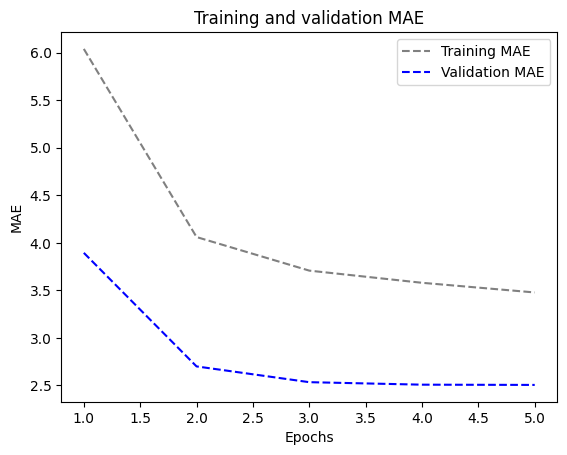

In [ ]:
import matplotlib.pyplot as plt
loss_r = history.history["mae"]
validation_loss_r = history.history["val_mae"]

epochs = range(1, len(loss_r) + 1)
plt.figure()
plt.plot(epochs, loss_r, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_r, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Bidirectional LSTM

In [ ]:
inputs = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history.bi = model.fit(training_data,
                    epochs=5,
                    validation_data=validation_data,
                     callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 60s 69ms/step - loss: 26.9525 - mae: 3.7438 - val_loss: 10.8113 - val_mae: 2.5374
Epoch 2/5
819/819 [==============================] - 56s 69ms/step - loss: 9.6893 - mae: 2.4294 - val_loss: 10.1908 - val_mae: 2.4766
Epoch 3/5
819/819 [==============================] - 56s 69ms/step - loss: 8.8017 - mae: 2.3146 - val_loss: 10.4460 - val_mae: 2.4892
Epoch 4/5
819/819 [==============================] - 56s 68ms/step - loss: 8.2644 - mae: 2.2443 - val_loss: 10.2690 - val_mae: 2.4701
Epoch 5/5
819/819 [==============================] - 56s 69ms/step - loss: 7.7806 - mae: 2.1777 - val_loss: 10.4468 - val_mae: 2.4885


In [ ]:
model_bi = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model_bi.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 12s 26ms/step - loss: 10.8667 - mae: 2.6133
Test MAE: 2.61


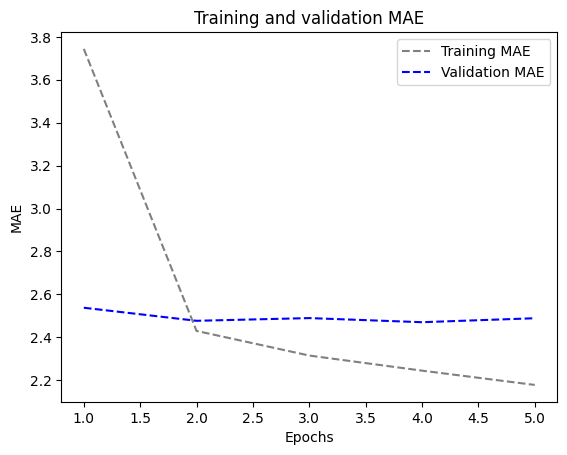

In [ ]:
import matplotlib.pyplot as plt
loss_bi = history.bi.history["mae"]
validation_loss_bi = history.bi.history["val_mae"]

epochs = range(1, len(loss_bi) + 1)
plt.figure()
plt.plot(epochs, loss_bi, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_bi, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

1D Convnets and LSTM togther

In [ ]:
input_final = keras.Input(shape=(sequencelength, raw_d.shape[-1]))
l = layers.Conv1D(64, 3, activation='relu')(input_final)
l = layers.MaxPooling1D(3)(l)
l = layers.Conv1D(128, 3, activation='relu')(l)
l = layers.GlobalMaxPooling1D()(l)
l = layers.Reshape((-1, 128))(l)  # Reshape the data to be 3D
l = layers.LSTM(16)(l)
output_final = layers.Dense(1)(l)
model_final = keras.Model(input_final, output_final)

model_final.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history_final = model_final.fit(training_data, epochs=5, validation_data=validation_data, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 19s 21ms/step - loss: 44.9916 - mae: 5.0203 - val_loss: 23.8418 - val_mae: 3.7942
Epoch 2/5
819/819 [==============================] - 17s 21ms/step - loss: 17.5950 - mae: 3.2490 - val_loss: 19.7089 - val_mae: 3.5343
Epoch 3/5
819/819 [==============================] - 17s 21ms/step - loss: 14.5223 - mae: 2.9633 - val_loss: 21.9687 - val_mae: 3.7803
Epoch 4/5
819/819 [==============================] - 17s 20ms/step - loss: 12.9081 - mae: 2.7891 - val_loss: 21.5879 - val_mae: 3.6461
Epoch 5/5
819/819 [==============================] - 17s 21ms/step - loss: 11.7557 - mae: 2.6533 - val_loss: 21.4855 - val_mae: 3.6584


In [ ]:
model_final = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model_final.evaluate(testing_data)[1]:.2f}")

405/405 [==============================] - 5s 10ms/step - loss: 23.1042 - mae: 3.8384
Test MAE: 3.84


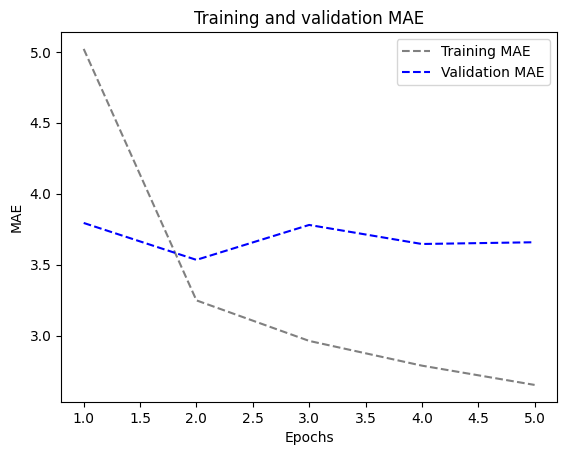

In [ ]:
import matplotlib.pyplot as plt
loss_final = history_final.history["mae"]
validation_loss_final = history_final.history["val_mae"]

epochs = range(1, len(loss_final) + 1)
plt.figure()
plt.plot(epochs, loss_final, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  validation_loss_final, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

Built 14 models: Following are the details;

Model 1: common-sense, non-machine-learning baseline

Model 2: A basic machine-learning model

Model 3: 1D convolutional model

Model 4: Simple RNN layer that can process sequences of any length

Model 5: Simple RNN - Stacking RNN layers

Model 6: A Simple GRU (Gated Recurrent Unit)

Model 7: LSTM-Simple

Model 8: LSTM - dropout Regularization

Model 9: Stacked setup with 16 units

Model 10: Stacked setup with 32 units

Model 11: Stacked setup with 8 units

Model 12: LSTM - dropout-regularized, stacked

Model 13: Bidirectional LSTM

Model 14: 1D Convnets and LSTM togther

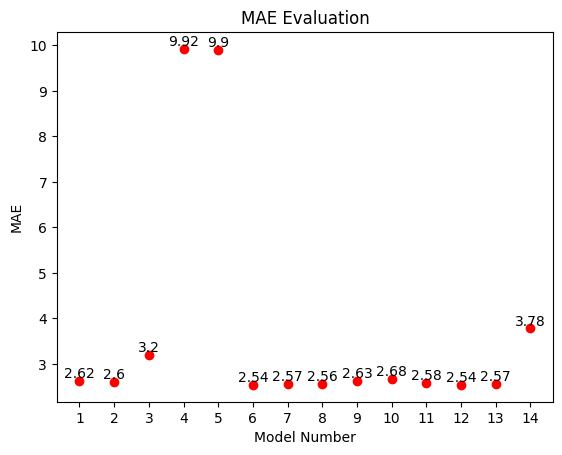

In [ ]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.60,3.2,9.92,9.9,2.54,2.57,2.56,2.63,2.68,2.58,2.54,2.57,3.78)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()
